In [20]:
from astroquery.gaia import Gaia
import warnings

# Comment this out if you want to see warnings
warnings.filterwarnings('ignore')
import astropy
import requests
import pyvo as vo
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import pandas as pd
import glob
import os
import requests
import sys
sys.path.append("../gaia_tools/")
import data_analysis
import covariance_generation as cov
from import_functions import import_data
from BinCollection import BinCollection

In [4]:
# Original sample
gaia_path = "/hdfs/local/sven/gaia_tools_data/gaia_rv_data_bayes.csv"
icrs_data = import_data(path = gaia_path, is_bayes = True, debug = False)

Start import...
The dimensions of the data: (rows, columns) -> (7133471, 24)
Checking indexing... 



In [5]:
# Gaia photometry data
gaia_phot_path = "/hdfs/local/sven/gaia_tools_data/gaia_photometry_rv_data.csv"
phot_data = pd.read_csv(gaia_phot_path)

In [8]:
merged_data = icrs_data.merge(phot_data, on='source_id', suffixes=('_gaia', '_phot'))
merged_data

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,...,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,bp_rp,bp_g,g_rp
0,5933266834310007808,242.471074,0.330682,-52.806533,0.125811,-0.108158,0.304873,-5.696558,0.414802,-4.721763,...,18.083382,182.758050,29.113286,19.696697,2823.044404,94.654811,16.135126,3.561571,1.613316,1.948256
1,4103049637327213440,278.887615,0.117672,-15.350780,0.103104,0.043251,0.117026,-1.918747,0.226716,-2.489130,...,16.126408,1819.765784,27.980929,17.201350,8155.307063,28.250495,14.983319,2.218030,1.074942,1.143088
2,5951114420631264640,260.139995,0.042137,-46.794507,0.038528,0.987297,0.051966,2.684643,0.077350,2.938682,...,15.499906,5555.703690,23.199597,15.989540,9299.009293,38.059019,14.840828,1.148712,0.489635,0.659078
3,5966712023814100736,255.893150,0.069434,-41.563702,0.055033,0.794860,0.068601,1.408253,0.127427,-3.243735,...,16.207378,2040.744021,10.191362,17.076918,6160.754812,18.125068,15.287835,1.789083,0.869539,0.919543
4,2198292118993038464,331.084711,0.039728,56.898851,0.041073,-0.001040,0.047783,-2.108741,0.083662,-1.341982,...,15.963890,1966.141565,21.985146,17.117352,9802.211677,18.701468,14.783609,2.333742,1.153461,1.180281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7133466,5959713078252724352,259.808524,0.251540,-41.875976,0.225424,0.787437,0.360985,-3.812104,0.497450,-4.169081,...,18.046457,1658.789881,360.278290,17.301910,3265.615068,411.190319,15.977008,1.324902,-0.744547,2.069449
7133467,4057347680607821696,267.904540,0.079733,-28.918109,0.072635,0.455464,0.090251,1.713806,0.158910,-1.967485,...,13.409966,38602.172972,86.264874,13.884859,63596.632504,64.864664,12.753335,1.131524,0.474894,0.656631
7133468,5827538590793373696,234.110954,0.084926,-61.528791,0.057224,0.215771,0.085564,-4.032992,0.139154,-1.557606,...,17.231018,944.360817,14.279363,17.913544,2367.288366,20.082549,16.326292,1.587252,0.682526,0.904726
7133469,4251811155377211776,280.393583,0.074122,-7.967930,0.074171,0.150858,0.092974,-0.382712,0.145909,-2.400412,...,16.439703,988.694559,14.481704,17.863733,6635.446217,23.955929,15.207245,2.656488,1.424030,1.232458


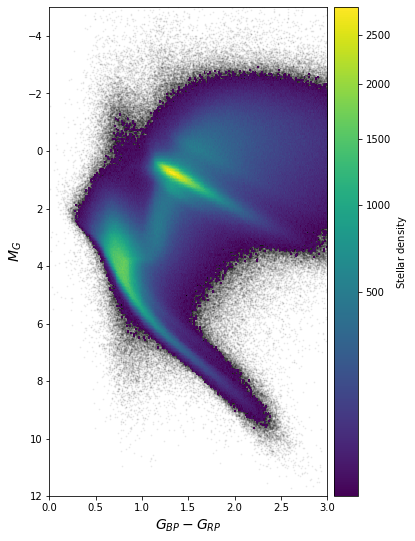

In [17]:
plt.rc('text', usetex=False)

fig, ax = plt.subplots(figsize=(6, 9))

range = [[0,5], [-10, 15]]

Mg = merged_data.phot_g_mean_mag - 5*np.log10(merged_data.r_est) + 5

# only show 2D-histogram for bins with more than 10 stars in them
h = ax.hist2d(merged_data.bp_rp, Mg, range=range, bins=500, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)
# fill the rest with scatter (set rasterized=True if saving as vector graphics)
ax.scatter(merged_data.bp_rp, Mg, alpha=0.05, s=1, color='k', zorder=0)

ax.invert_yaxis()
cb = fig.colorbar(h[3], ax=ax, pad=0.02)
ax.set_xlabel('$G_{BP} - G_{RP}$', fontdict={'size' : 14})
ax.set_ylabel('$M_G$', fontdict={'size' : 14})
cb.set_label("$\mathrm{Stellar~density}$")
plt.xlim(0,3)
plt.ylim(12,-5)
plt.show()

In [18]:
from scipy import stats

merged_data['Mg'] = merged_data.phot_g_mean_mag - 5*np.log10(merged_data.r_est) + 5

c = merged_data.radial_velocity

H, xedges, yedges, binnumber = stats.binned_statistic_2d(merged_data.bp_rp, merged_data.Mg, values = c, range = [[0, 3], [-4, 12]], bins=(10,1), statistic='mean')

In [21]:
XX, YY = np.meshgrid(xedges, yedges)

# Assign a binnumber for each data entry
merged_data['Bin_index'] = binnumber

# Instantiate a BinCollection object
bin_collection = BinCollection(merged_data, (10,1), XX, YY, YY, mode='r-z')

# Generate the bins with respective r-z boundaries
bin_collection.GenerateBins()

In [25]:
np.mean(bin_collection.bins[9].data.bp_rp)

2.8386367379889634